# 라이브러리

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import re
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')

In [4]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

# 데이터 전처리

## 결측치 처리
- 학군 정보가 없는 결측치를 발견. 일단은 제외하고 진행.

In [5]:
df = df[df['school_name']!=''].reset_index(drop=True).copy()

## 숫자형 자료

In [6]:
df['apartment_floor_min'] = pd.to_numeric(df['apartment_floor_min'])
df['apartment_floor_max'] = pd.to_numeric(df['apartment_floor_max'])
df['school_students'] = pd.to_numeric(df['school_students'])
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: re.split('\d',x)[0])

### 정규화

In [7]:
from sklearn.preprocessing import StandardScaler
def standard_scaler(data, var_name):
    scaler = StandardScaler()
    data[var_name] = scaler.fit_transform(data[var_name].values.reshape(-1,1))
    return data

In [8]:
var_num = ['apartment_floor_min',
             'apartment_floor_max',
             'apartment_parking',
             'school_students',
             'st_dist',
             'st_volume']

for var in var_num:
    df = standard_scaler(df, var)

## 범주형 자료

In [9]:
var_cate = ['district_id',
            'apartment_addr_town',
            'apartment_builder',
            'apartment_build_year',
            'apartment_build_month',
            'school_name',
            'school_addr_district',
            'school_addr_town',
            'st_name']
var_label = ['apartment_addr_town',
             'apartment_builder',
             'school_name',
             'school_addr_district',
             'school_addr_town',
             'st_name']

In [10]:
from sklearn.preprocessing import LabelEncoder
def label_encoding(data, var_name):
    encoder = LabelEncoder()
    data[var_name] = encoder.fit_transform(data[var_name])
    return data

### 라벨링

In [11]:
for var in var_label:
    df = label_encoding(df, var)

# Modeling 

## K-Prototypes Clustering

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7176 entries, 0 to 7175
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   district_id            7176 non-null   int64  
 1   apartment_id           7176 non-null   int64  
 2   apartment_addr_town    7176 non-null   int32  
 3   apartment_builder      7176 non-null   int32  
 4   apartment_build_year   7176 non-null   int64  
 5   apartment_build_month  7176 non-null   int64  
 6   apartment_floor_min    7176 non-null   float64
 7   apartment_floor_max    7176 non-null   float64
 8   apartment_parking      7176 non-null   float64
 9   apartment_name         7176 non-null   object 
 10  district_name          7176 non-null   object 
 11  school_name            7176 non-null   int32  
 12  school_dist            7176 non-null   int64  
 13  school_addr_district   7176 non-null   int64  
 14  school_addr_town       7176 non-null   int32  
 15  scho

In [2]:
train = df[var_cate + var_num]
print(len(var_cate))

NameError: name 'df' is not defined

In [1]:
train.head(5)

NameError: name 'train' is not defined

In [19]:
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(n_clusters=10, verbose=0, random_state=0)
train['cluster'] = kproto.fit_predict(train, categorical=list(range(len(var_cate))))

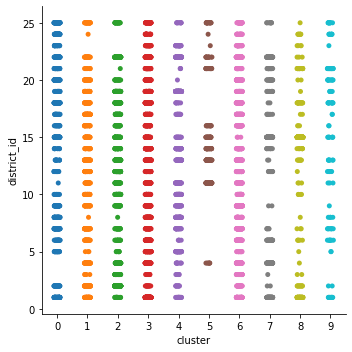

In [20]:
sns.catplot(data=train, x='cluster', y='district_id')